In [9]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.10, axis=0)
    upper = np.quantile(samples, 0.90, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define models ##

In [3]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

# gpt3_hypers = dict(
#     temp=0.7,
#     alpha=[0.95],
#     beta=[0.3],
#     basic=False,
#     settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
# )


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3': get_llmtime_predictions_data,
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

## Running LLMTime and Visualizing Results ##

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'text-davinci-003', 'temp': 0.7, 'identity': True, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point=''), 'dataset_name': 'linear_cos'}) 
 with NLL inf


100%|██████████| 1/1 [00:13<00:00, 13.40s/it]
CUDA backend failed to initialize: Found CUDA version 12000, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


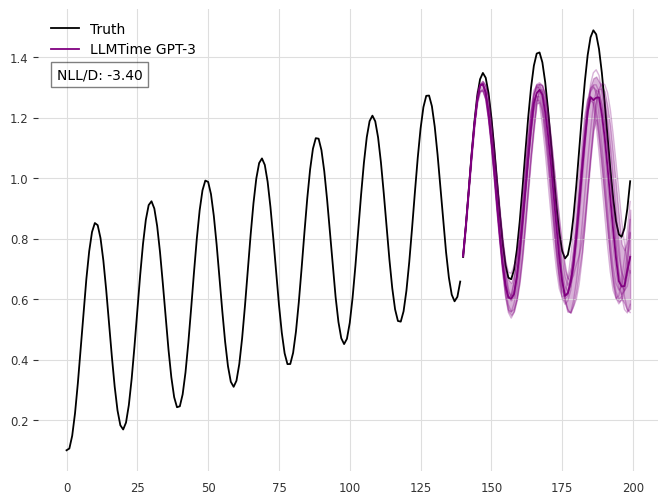

In [3]:
from data.synthetic import get_synthetic_datasets
datasets = get_synthetic_datasets()
ds_name = 'linear_cos'

# # datasets = get_datasets()
# # ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)
    break

In [ ]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'
data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)

square


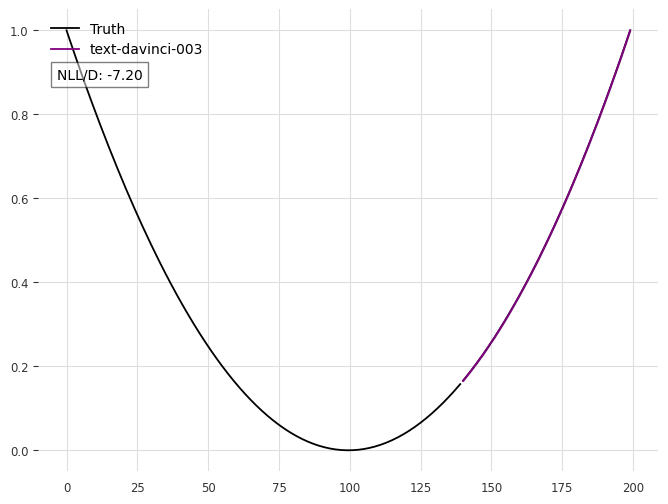

sine


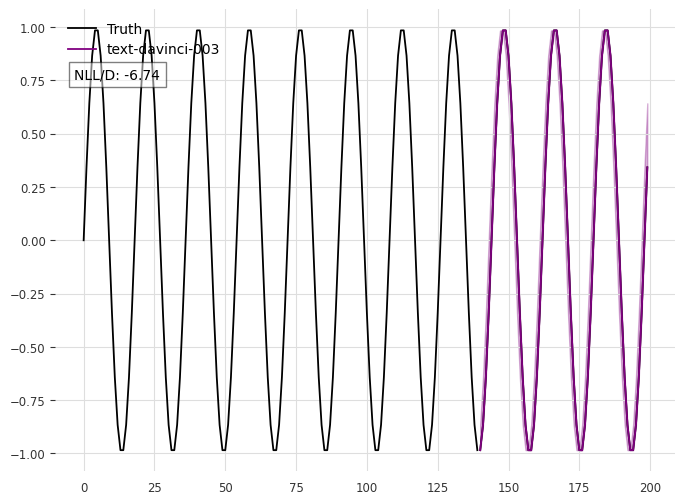

linear


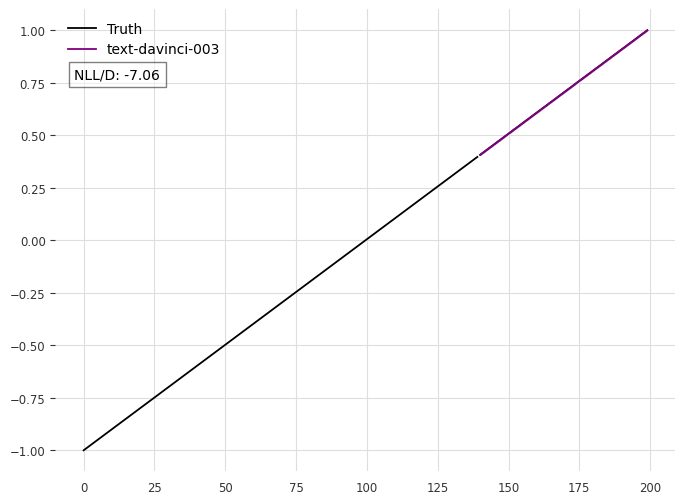

beat


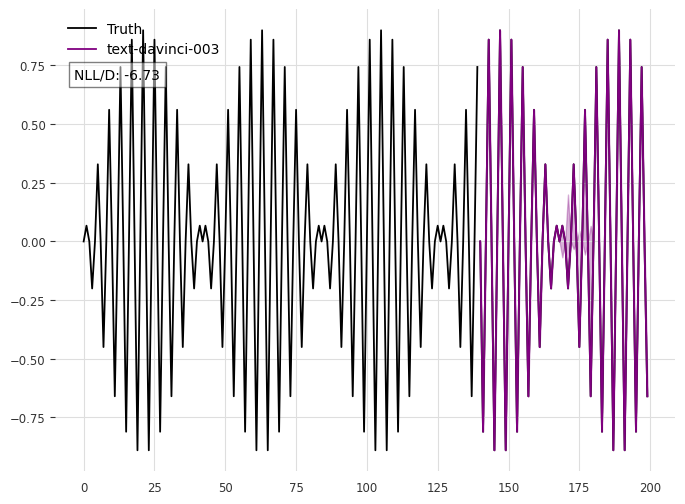

sinc


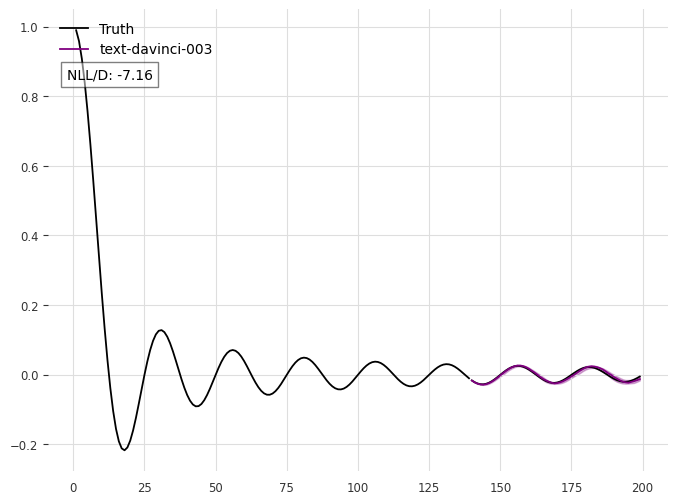

xsin


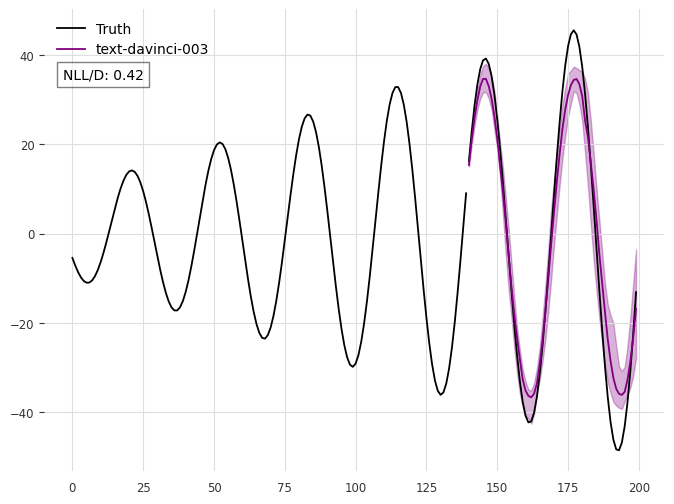

x_times_sine


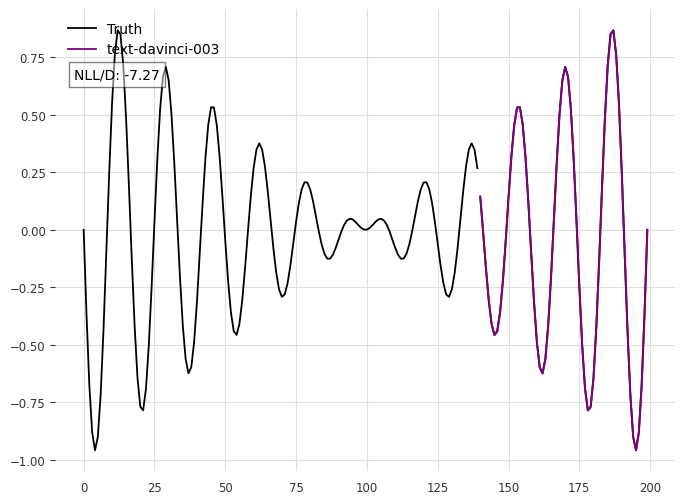

sigmoid


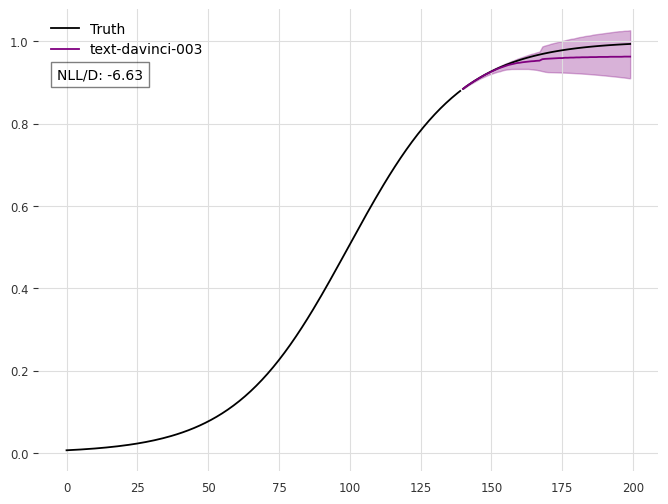

linear_cos


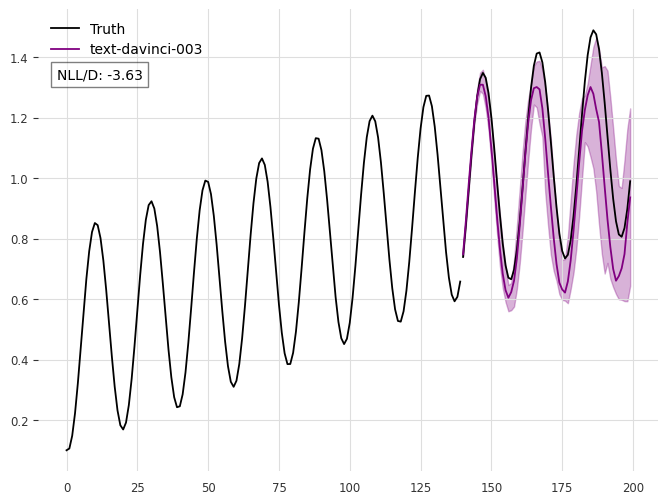

log


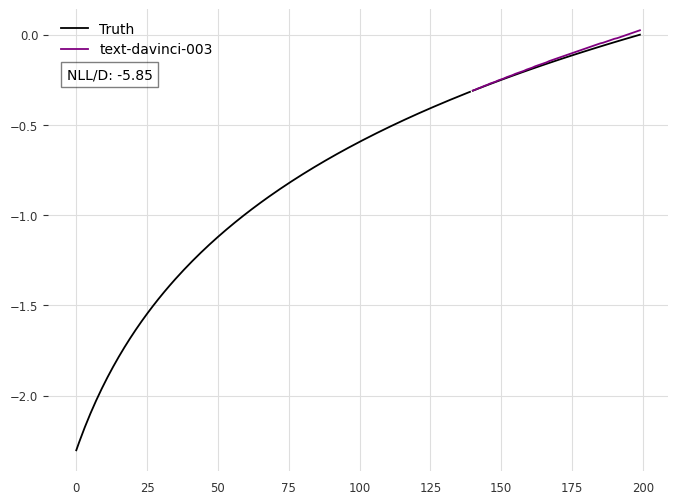

exp


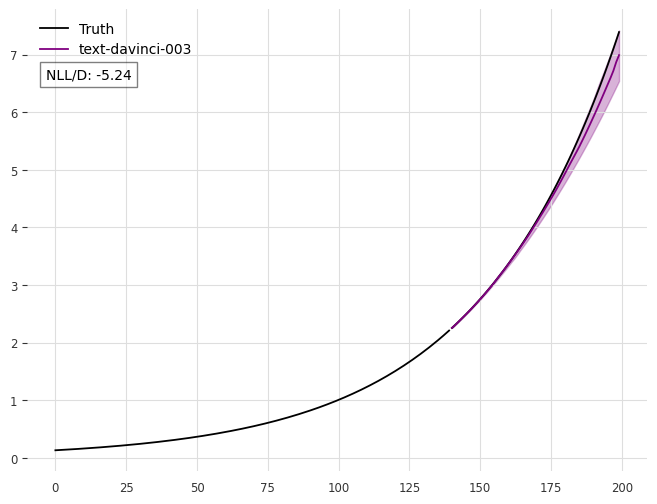

gaussian_wave


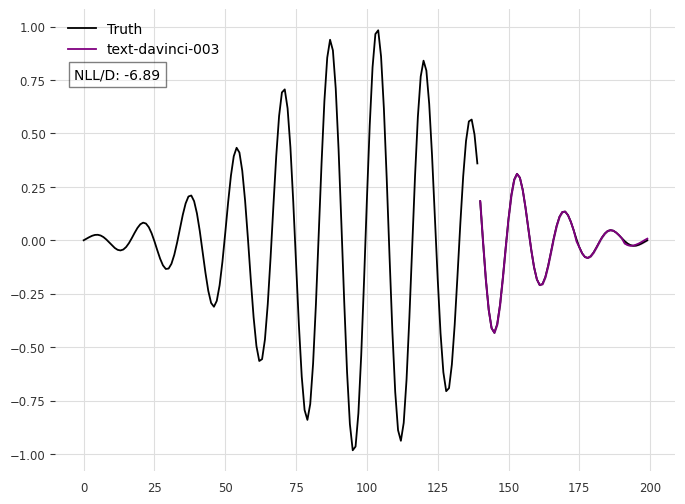

In [17]:
from glob import glob
import pickle
from data.synthetic import get_synthetic_datasets

# datasets = get_datasets()
# output_dir = 'precomputed_outputs/darts'

datasets = get_synthetic_datasets()
output_dir = 'test/synthetic_tuned'

for ds_name, data in datasets.items():
    data = datasets[ds_name]
    train, test = data
    print(ds_name)
    if os.path.exists(f'{output_dir}/{ds_name}.pkl'):
        with open(f'{output_dir}/{ds_name}.pkl', 'rb') as f:
            out = pickle.load(f)
        for model in out:
            if model == 'text-davinci-003':
                plot_preds(train, test, out[model], model, show_samples=False)